<a href="https://colab.research.google.com/github/d-portugal/chest_x_ray/blob/main/chest_xray_APA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Packages**

In [1]:
import pandas as pd
import numpy as np
import os, sys
import zipfile          
from zipfile import ZipFile
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

Importar dados

In [2]:
#Download do arquivo zip pelo google drive
!gdown 14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp
!gdown 1ZOUWiOyFPYCsexynx0MlpPxmPumy1QZu

#Diretório do zip
chest_xray = "/content/chest_xray.zip"
vgg16 = "/content/vgg16-pretrained-base.zip"

#Diretório para o arquivo extraido
target_dir = "/content/sample_data/dataset"
target_dir2 = "/content/sample_data/vgg16"

#Extração
zfile = zipfile.ZipFile(chest_xray)
zfile.extractall(target_dir)

zfile = zipfile.ZipFile(vgg16)
zfile.extractall(target_dir2)

Downloading...
From: https://drive.google.com/uc?id=14aHeQoLFL9zu-VEKmZTTUFWIfNCfRkQp
To: /content/chest_xray.zip
100% 1.15G/1.15G [00:10<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZOUWiOyFPYCsexynx0MlpPxmPumy1QZu
To: /content/vgg16-pretrained-base.zip
100% 54.8M/54.8M [00:00<00:00, 119MB/s]


Definições

In [3]:
#Caminhos das pastas de treino, teste e validação

train_path = '/content/sample_data/dataset/chest_xray/treinamento'
valid_path = '/content/sample_data/dataset/chest_xray/validacao'

#Tamanho das imagens

img_height = 32
img_width = 32

#Quantidade de imagens que será utilizada a cada iteração

batch_size = 1000 

#Quantidade de classes
num_classes = 3

#Reproducibilidade
def set_seed(seed=1):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

Carregar imagens

In [4]:
ds_train = image_dataset_from_directory(
    train_path,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = [img_height, img_width],
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

ds_valid = image_dataset_from_directory(
    valid_path,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = [img_height, img_width],
    interpolation = 'nearest',
    batch_size = batch_size,
    shuffle = True
)

Found 5065 files belonging to 3 classes.
Found 166 files belonging to 3 classes.


---

Visualização das imagens

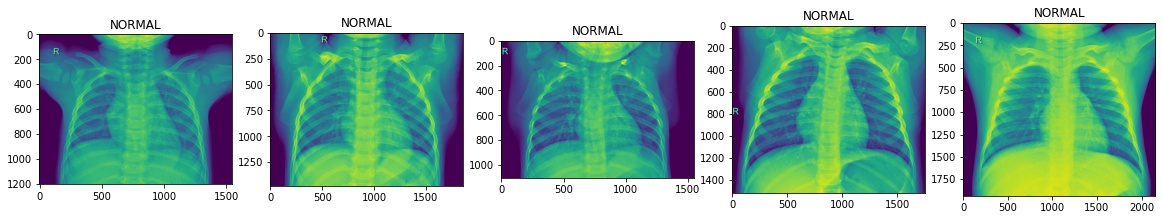

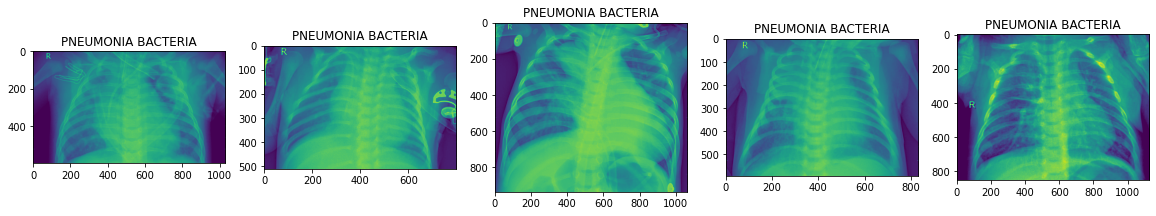

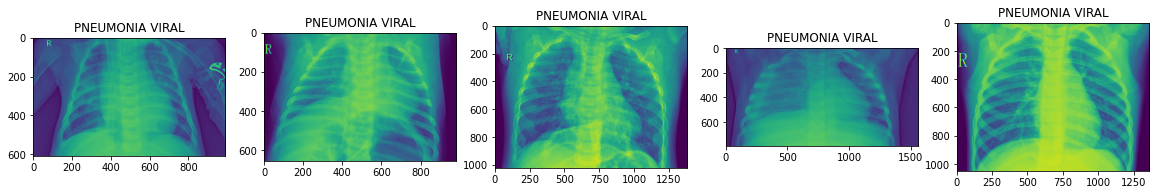

In [5]:
directory = os.listdir(train_path)
for each in directory:
    plt.figure(figsize = (20, 20))
    currentFolder = train_path + '/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:5]):
        fullpath = currentFolder + "/" + file
        img = mpimg.imread(fullpath)
        plt.subplot(2, 5, i+1)
        plt.title(each)
        plt.imshow(img)

---

Modelagem

1.   CNN

In [ ]:
model = keras.Sequential([
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 3), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 3), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 3), padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 3), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

2.   CNN + Data Augmentation

In [ ]:
model_aug = keras.Sequential([
    preprocessing.RandomContrast(factor = 0.5),
    preprocessing.RandomFlip(mode = 'horizontal'),
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu', input_shape=(img_width, img_height, 1), padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [ ]:
model_aug.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

3.  CNN + Data Augmentation + Transfer Learning  

In [7]:
pretrained_base = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))

pretrained_base.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [8]:
model_aug_transf = keras.Sequential([
    preprocessing.RandomContrast(factor = 0.5),
    preprocessing.RandomFlip(mode = 'horizontal'),
    pretrained_base,
    layers.Flatten(),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dense(units = 3, activation = 'softmax')
])

In [9]:
model_aug_transf.compile(
    optimizer = tf.keras.optimizers.Adam(epsilon = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

----

Treinamento

In [ ]:
tf.get_logger().setLevel('ERROR') #Suprimir warnings to Tensorflow devido ao looping utilizado no Data Augmentation

1. CNN

In [ ]:
history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5)
)

Epoch 1/50
6/6 [==============================] - 48s 3s/step - loss: 20.9195 - accuracy: 0.3917 - val_loss: 3.3217 - val_accuracy: 0.4940
Epoch 2/50
6/6 [==============================] - 45s 3s/step - loss: 2.9830 - accuracy: 0.3015 - val_loss: 1.2663 - val_accuracy: 0.5482
Epoch 3/50
6/6 [==============================] - 45s 3s/step - loss: 1.2702 - accuracy: 0.4918 - val_loss: 1.0485 - val_accuracy: 0.3795
Epoch 4/50
6/6 [==============================] - 45s 3s/step - loss: 1.0096 - accuracy: 0.4460 - val_loss: 1.0469 - val_accuracy: 0.4217
Epoch 5/50
6/6 [==============================] - 45s 3s/step - loss: 0.9167 - accuracy: 0.6041 - val_loss: 0.9770 - val_accuracy: 0.5000
Epoch 6/50
6/6 [==============================] - 45s 3s/step - loss: 0.8349 - accuracy: 0.6492 - val_loss: 0.8730 - val_accuracy: 0.5843
Epoch 7/50
6/6 [==============================] - 46s 3s/step - loss: 0.7802 - accuracy: 0.6452 - val_loss: 0.7945 - val_accuracy: 0.6687
Epoch 8/50
6/6 [=================

In [ ]:
history_frame = pd.DataFrame(history.history)
print(history_frame)

         loss  accuracy  val_loss  val_accuracy
0   20.919453  0.391708  3.321665      0.493976
1    2.983003  0.301481  1.266275      0.548193
2    1.270239  0.491807  1.048525      0.379518
3    1.009554  0.446002  1.046946      0.421687
4    0.916696  0.604146  0.977008      0.500000
5    0.834879  0.649161  0.872994      0.584337
6    0.780163  0.645212  0.794492      0.668675
7    0.723782  0.681935  0.719234      0.692771
8    0.687491  0.686081  0.647978      0.740964
9    0.656386  0.721422  0.622717      0.753012
10   0.640771  0.734650  0.598135      0.759036
11   0.612175  0.732478  0.587508      0.716867
12   0.588571  0.753801  0.567487      0.753012
13   0.568292  0.756170  0.593725      0.746988
14   0.539484  0.771372  0.596207      0.746988
15   0.531893  0.773346  0.600092      0.746988
16   0.522519  0.775123  0.532165      0.740964
17   0.507493  0.784205  0.491737      0.795181
18   0.496027  0.790918  0.504260      0.777108
19   0.495603  0.780652  0.508078      0

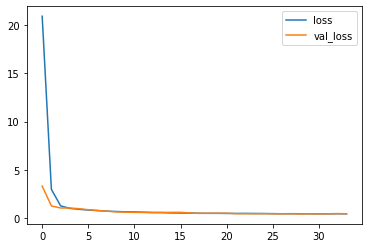

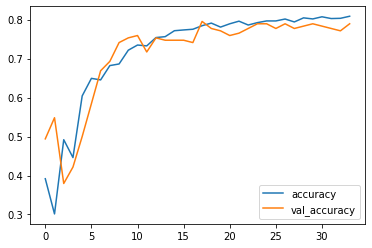

In [ ]:
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

2.   CNN + Data Augmentation

In [ ]:
history_aug = model_aug.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5)
)

Epoch 1/50
6/6 [==============================] - 51s 4s/step - loss: 40.0166 - accuracy: 0.3465 - val_loss: 5.9392 - val_accuracy: 0.2349
Epoch 2/50
6/6 [==============================] - 51s 3s/step - loss: 3.3961 - accuracy: 0.4091 - val_loss: 3.2780 - val_accuracy: 0.2169
Epoch 3/50
6/6 [==============================] - 50s 4s/step - loss: 1.8448 - accuracy: 0.3957 - val_loss: 1.0368 - val_accuracy: 0.5964
Epoch 4/50
6/6 [==============================] - 50s 4s/step - loss: 1.1474 - accuracy: 0.3955 - val_loss: 0.9938 - val_accuracy: 0.4458
Epoch 5/50
6/6 [==============================] - 49s 4s/step - loss: 0.9841 - accuracy: 0.5688 - val_loss: 1.0877 - val_accuracy: 0.4398
Epoch 6/50
6/6 [==============================] - 49s 3s/step - loss: 0.9065 - accuracy: 0.5824 - val_loss: 0.8334 - val_accuracy: 0.6446
Epoch 7/50
6/6 [==============================] - 49s 3s/step - loss: 0.8531 - accuracy: 0.6144 - val_loss: 0.8069 - val_accuracy: 0.6807
Epoch 8/50
6/6 [=================

In [ ]:
history_aug_frame = pd.DataFrame(history_aug.history)
print(history_aug_frame)

         loss  accuracy  val_loss  val_accuracy
0   40.016624  0.346496  5.939169      0.234940
1    3.396092  0.409082  3.278029      0.216867
2    1.844848  0.395656  1.036849      0.596386
3    1.147375  0.395459  0.993836      0.445783
4    0.984133  0.568806  1.087725      0.439759
5    0.906540  0.582428  0.833404      0.644578
6    0.853113  0.614413  0.806887      0.680723
7    0.810452  0.647384  0.735588      0.710843
8    0.768915  0.680355  0.748275      0.680723
9    0.734698  0.694373  0.703150      0.710843
10   0.701599  0.706219  0.696744      0.734940
11   0.665659  0.730306  0.686970      0.716867
12   0.651907  0.725962  0.661990      0.722892
13   0.638454  0.728529  0.605425      0.740964
14   0.610518  0.741560  0.613237      0.722892
15   0.602455  0.750839  0.550623      0.746988
16   0.604905  0.742942  0.520956      0.759036
17   0.592514  0.745903  0.502616      0.759036
18   0.573567  0.753998  0.508538      0.771084
19   0.558851  0.759921  0.552987      0

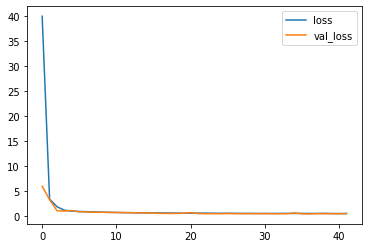

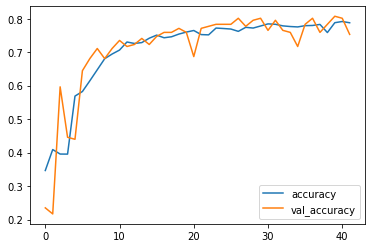

In [ ]:
history_aug_frame.loc[:, ['loss', 'val_loss']].plot()
history_aug_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

3.   CNN + Data Augmentation + Transfer Learning

In [ ]:
history_aug_transfer = model_aug_transf.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 50,
    verbose = 1,
    callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=5)
)

Epoch 1/50


6/6 [==============================] - 91s 10s/step - loss: 6.2545 - accuracy: 0.4436 - val_loss: 3.0937 - val_accuracy: 0.6627
Epoch 2/50
6/6 [==============================] - 92s 10s/step - loss: 3.5413 - accuracy: 0.6120 - val_loss: 3.1979 - val_accuracy: 0.6687
Epoch 3/50
6/6 [==============================] - 100s 10s/step - loss: 2.9559 - accuracy: 0.6523 - val_loss: 2.8163 - val_accuracy: 0.6988
Epoch 4/50
6/6 [==============================] - 97s 10s/step - loss: 2.4852 - accuracy: 0.6861 - val_loss: 2.2925 - val_accuracy: 0.6506
Epoch 5/50
6/6 [==============================] - 97s 10s/step - loss: 2.0947 - accuracy: 0.6885 - val_loss: 1.9880 - val_accuracy: 0.6807
Epoch 6/50
6/6 [==============================] - 93s 10s/step - loss: 1.8838 - accuracy: 0.6977 - val_loss: 1.9026 - val_accuracy: 0.6627
Epoch 7/50
6/6 [==============================] - 93s 9s/step - loss: 1.8353 - accuracy: 0.6879 - val_loss: 1.8436 - val_accuracy: 0.7048
Epoch 8/50
6/6 [======================

In [ ]:
history_aug_transfer = pd.DataFrame(history_aug_transfer.history)
print(history_aug_frame)

In [ ]:
history_aug_transfer.loc[:, ['loss', 'val_loss']].plot()
history_aug_transfer.loc[:, ['accuracy', 'val_accuracy']].plot();

Model Saves

In [ ]:
model.save()
model_aug.save()
model_aug_transfer.save()